# Es un gato??
Esto es un dataset que contiene dos tipos de imagenes: gatos y no-gatos.
La idea es que entrenen un clasificador sobre las imágenes que pueda determinar a que calse pertenecen las mismas.
El notebook tiene implementada toda la parte de adecuación de las imágenes (las deja hechas una matriz con las que estamos acostumbrados a trabajar), les queda a ustedes trabajar libremente sobre la parte de implementación de un clasificador.

## 1 - Librerias necesarias ##
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.
- [PIL](http://www.pythonware.com/products/pil/) and [scipy](https://www.scipy.org/) are used here to test your model with your own picture at the end.

In [2]:
!conda install h5py -y
!conda install scipy -y
!conda install pillow -y

Solving environment: done

## Package Plan ##

  environment location: /home/usuario/anaconda3/envs/acamica

  added / updated specs:
    - h5py


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    blas-1.0                   |              mkl           6 KB
    h5py-2.7.1                 |np114py36_intel_0         3.7 MB  intel
    libedit-3.1.20181209       |       hc058e9b_0         188 KB
    libgfortran-ng-7.3.0       |       hdf63c60_0         1.3 MB
    mkl-2018.0.3               |          intel_1       198.7 MB  intel
    notebook-5.2.2             |     py36_intel_0         6.1 MB  intel
    numpy-base-1.15.0          |   py36h1793315_0         4.2 MB
    sqlite-3.30.1              |       h7b6447c_0         1.9 MB
    terminado-0.8.1            |     py36_intel_0          20 KB  intel
    widgetsnbextension-3.2.0   |           py36_0         1.7 MB  intel
    xz-5.2.4            

numpy-base-1.15.0    | 4.2 MB    | ##################################### | 100% 
libedit-3.1.20181209 | 188 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset

%matplotlib inline

/home/usuario/anaconda3/envs/acamica/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 2 - Explorando el Dataset ##

Tenemos un dataset ("data.h5") que contiene:
    - a training set of m_train images labeled as cat (y=1) or non-cat (y=0)
    - a test set of m_test images labeled as cat or non-cat
    - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB). Thus, each image is square (height = num_px) and (width = num_px).

Veamos alguna de las imagenes

In [6]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

Le agregamos el _orig a los nombres de las variables para diferencia estas imagenes que levantamos de los datos, respecto al train_set_x que quedará luego del preprocesamiento

Cada linea del dataset representa uan imagen, Se peude vizualizar la imagen con indice 'index' meidante el siguiente código:

y = [1], it's a 'cat' picture.


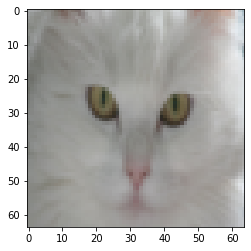

In [7]:
# Example of a picture
index = 50
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

Many software bugs in deep learning come from having matrix/vector dimensions that don't fit. If you can keep your matrix/vector dimensions straight you will go a long way toward eliminating many bugs. 

Definimos las siguietnes cantidades que nos serán de interés:
    - m_train (number of training examples)
    - m_test (number of test examples)
    - num_px (= height = width of a training image)

Recuerden que `train_set_x_orig` es un array de numpy con dimensiones: (m_train, num_px, num_px, 3).

In [37]:
m_train = len(train_set_x_orig)
m_test = len(test_set_x_orig)
num_px = test_set_x_orig.shape[1]


print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


La ùltima dimensiòn de las imàgenes corresponde a los 3 colores (R,G,B). Para trabajar con un dataset de menores dimensiones, vamos a transformar las imágenes a escala de grises con el siquiente codigo:

In [14]:
# Transformamos el Training set
grey_train_set_x_orig =  np.zeros([m_train,num_px,num_px])
for l in range(m_train):
    for i in range(64):
        for j in range(64):
            R = train_set_x_orig[l,i,j,0]
            G = train_set_x_orig[l,i,j,1]
            B = train_set_x_orig[l,i,j,2]
            grey_train_set_x_orig[l,i,j] = 0.2989*R + 0.5870*G + 0.1140*B

In [16]:
# Transformamos el Test set
grey_test_set_x_orig =  np.zeros([m_test,num_px,num_px])
for l in range(m_test):
    for i in range(64):
        for j in range(64):
            R = test_set_x_orig[l,i,j,0]
            G = test_set_x_orig[l,i,j,1]
            B = test_set_x_orig[l,i,j,2]
            grey_test_set_x_orig[l,i,j] = 0.2989*R + 0.5870*G + 0.1140*B

Luego hacemos un reshape, esto quiere decir que vamos a transformar las imagenes de las cuadricluas de 64 x 64 en las cuales vienen , a un vector unidimensional de 4096 posiciones. Es decir, representamos la imagen como una "tira" de numeros en lugar de un "cuadrado" de numeros:

In [23]:
train_set_x_flatten = grey_train_set_x_orig.reshape(train_set_x_orig.shape[0],-1)
train_set_x_flatten.shape

(209, 4096)

In [24]:
test_set_x_flatten = grey_test_set_x_orig.reshape(test_set_x_orig.shape[0],-1)
test_set_x_flatten.shape

(50, 4096)

In [27]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

In [34]:
print ("train_set_x_flatten shape: " + str(train_set_x.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x_flatten shape: (209, 4096)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (50, 4096)
test_set_y shape: (1, 50)


In [ ]:
## ACA CODEAN USTEDES CON TODO LO QUE FUIMOS APRENDIENDO HASTA AHORA

Luego peuden chequear las predicciones de su modelo sobre imagenes del test_set en particualar utilizando el siguiente codigo que reproduce una imagen determinada del test_set:

IndexError: index 166 is out of bounds for axis 0 with size 2

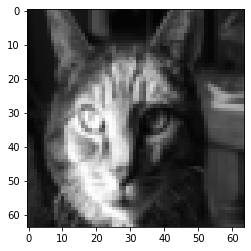

In [38]:
# Example of a picture
index = 30
plt.imshow(test_set_x_orig[index])
print ("y = " + str(test_set_y[:, index]) + ", it's a '" + classes[np.squeeze(test_set_x_orig[:, index])].decode("utf-8") +  "' picture.")